# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём пользователь сможет быстро узнать рыночную стоимость своего автомобиля. 

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель** - построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
#загружаем необходимые библиотеки
!pip install skimpy
!pip install catboost
!pip install lightgbm
!pip install sklearn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from skimpy import clean_columns


In [2]:
RANDOM = 123

warnings.filterwarnings('ignore')
model_list = []
rmse_score_list = []
best_params = []

In [3]:
#загружаем датасет
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('/Users/amirk/Downloads/autos.csv')

### Анализ данных

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
data.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [8]:
# приведем названия столбцов к стандартному виду
data = clean_columns(data)

16 column names have been cleaned

In [9]:
#сразу обращает на себя внимание столбец nimber_of_pictures, все значения равны 0. 
#Столбец неинформативный, если нет возможности восстановить данные, то удаляем его.
data.drop('number_of_pictures', axis=1, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


In [11]:
# найдем и удалим явные дубликаты
data.duplicated().sum()

4

In [12]:
data.drop_duplicates(inplace=True)

In [13]:
# переведем столбцы с датами в datetime формат

data.loc[:, ['date_crawled', 'date_created', 'last_seen']] = pd.to_datetime \
(data.loc[:, ['date_crawled', 'date_created', 'last_seen']].stack()).unstack()

Пройдемся по всем столбцам, просмотрим выбросы и аномалии

In [14]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Год регистрации не может быть равен 1000, 3000, 9999 и т.д. Это либо ошибка сбора информации, либо заглушки, о значении которых нужно узнавать у заказчика. На данный момент удалим  указанные значения

In [15]:
data.query('1910 <= registration_year <= 2020', inplace=True)

In [16]:
data['registration_year'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype=int64)

Года имеют правильную размерность!

In [17]:
data['registration_month'].value_counts()

0     37220
3     34368
6     31500
4     29266
5     29149
7     27208
10    26098
12    24287
11    24184
9     23811
1     23213
8     22626
2     21264
Name: registration_month, dtype: int64

Номер месяца не может быть равен 0, вероятно опять какая-то ошибка или заглушка, нужно уточнять. Пока заменим данные значения на первый месяц, т.к. более значимый признак это год и удалять 10% выборки не совсем верно.

In [18]:
data['registration_month'].replace({0:1}, inplace=True)

In [19]:
data['registration_month'].value_counts()

1     60433
3     34368
6     31500
4     29266
5     29149
7     27208
10    26098
12    24287
11    24184
9     23811
8     22626
2     21264
Name: registration_month, dtype: int64

Месяца имеют правильные номера!

Создадим столбец с датой регистрации автомобиля. Дата регистрации автомобиля должна быть раньше, чем дата регистрации анкеты и даты выгрузки объявления. Проверим везде ли это соблюдено или есть ошибки. Если есть ошибки, то удалим их.

In [20]:
# создадим столбец с датой регистрации автомобиля
data['date_registration'] = pd.to_datetime(dict(year=data['registration_year'], 
                                                month=data['registration_month'], 
                                                day=np.ones(len(data))))

In [21]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code,last_seen,date_registration
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,1,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57,1993-01-01
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50,2011-05-01
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46,2004-08-01
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17,2001-06-01
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21,2008-07-01


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354194 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354194 non-null  datetime64[ns]
 1   price               354194 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354194 non-null  int64         
 4   gearbox             334499 non-null  object        
 5   power               354194 non-null  int64         
 6   model               334564 non-null  object        
 7   kilometer           354194 non-null  int64         
 8   registration_month  354194 non-null  int64         
 9   fuel_type           321427 non-null  object        
 10  brand               354194 non-null  object        
 11  repaired            283187 non-null  object        
 12  date_created        354194 non-null  datetime64[ns]
 13  postal_code         354194 no

Столбец добавлен!

In [23]:
# Удалим ошибки
data.query('date_registration <= date_created <= date_crawled', inplace=True)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334539 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        334539 non-null  datetime64[ns]
 1   price               334539 non-null  int64         
 2   vehicle_type        316826 non-null  object        
 3   registration_year   334539 non-null  int64         
 4   gearbox             317110 non-null  object        
 5   power               334539 non-null  int64         
 6   model               317580 non-null  object        
 7   kilometer           334539 non-null  int64         
 8   registration_month  334539 non-null  int64         
 9   fuel_type           309396 non-null  object        
 10  brand               334539 non-null  object        
 11  repaired            271909 non-null  object        
 12  date_created        334539 non-null  datetime64[ns]
 13  postal_code         334539 no

Ошибки удалены!

In [25]:
data['date_crawled'].sort_values()

329497   2016-03-05 14:06:22
220583   2016-03-05 14:06:23
324763   2016-03-05 14:06:24
99885    2016-03-05 14:06:24
176823   2016-03-05 14:06:24
                 ...        
204218   2016-04-07 14:36:53
53739    2016-04-07 14:36:54
301030   2016-04-07 14:36:55
339649   2016-04-07 14:36:56
90713    2016-04-07 14:36:58
Name: date_crawled, Length: 334539, dtype: datetime64[ns]

Аномалий нет!

In [26]:
data['date_created'].sort_values()

61207    2014-03-10
4001     2015-03-20
342275   2015-06-18
86601    2015-08-07
175103   2015-08-10
            ...    
261323   2016-04-07
230672   2016-04-07
28141    2016-04-07
313707   2016-04-07
111138   2016-04-07
Name: date_created, Length: 334539, dtype: datetime64[ns]

Аномалий нет!

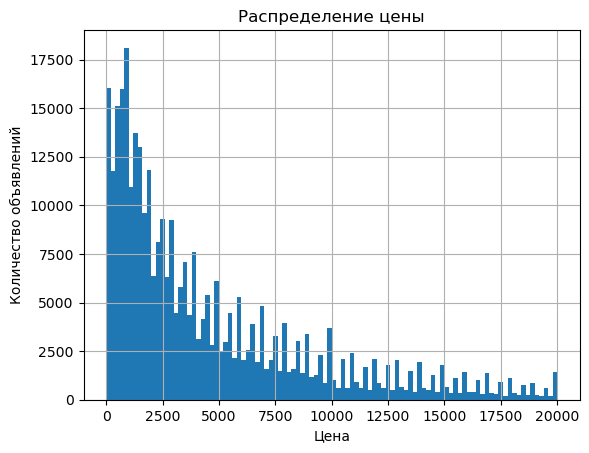

In [27]:
data['price'].hist(bins=100)
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')
plt.title('Распределение цены')
plt.show()

In [28]:
data[data['price'] == 0]['price'].count()

9746

Цена вряд ли может быть равна 0,вероятно это ошибка сбора информации. Удалим данные строки.

In [29]:
data = data.query('price > 0')

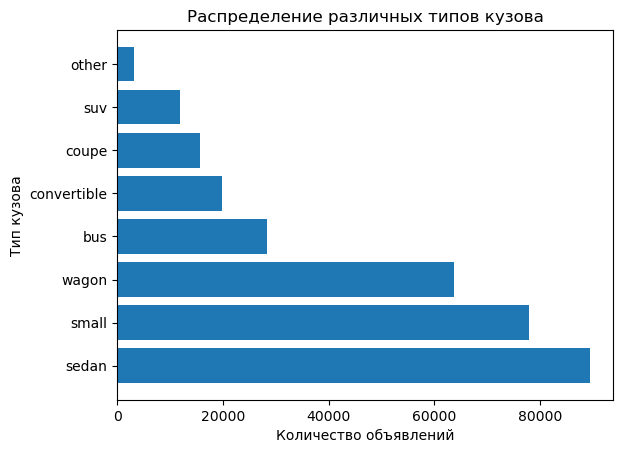

In [30]:
plt.barh(data['vehicle_type'].value_counts().index, data['vehicle_type'].value_counts())
plt.xlabel('Количество объявлений')
plt.ylabel('Тип кузова')
plt.title('Распределение различных типов кузова')
plt.show()

Сделаем предположение, что пропуски в vehicle_type можно найти по **brand, model, power, gearbox, fuel_type**. Посмотрим, автомобили с одинаковыми характеристиками имели только один тип кузова или несколько

In [31]:
data.loc[:, ['brand', 'model','power', 'gearbox', 'fuel_type', 'vehicle_type']]. \
groupby(['brand', 'model', 'power','gearbox', 'fuel_type'], as_index=False).agg('nunique')


,brand,model,power,gearbox,fuel_type,vehicle_type
0,alfa_romeo,145,0,manual,petrol,2
1,alfa_romeo,145,66,manual,petrol,1
2,alfa_romeo,145,72,manual,petrol,1
3,alfa_romeo,145,90,manual,petrol,1
4,alfa_romeo,145,100,manual,petrol,2
...,...,...,...,...,...,...
17552,volvo,xc_reihe,267,auto,petrol,1
17553,volvo,xc_reihe,272,auto,petrol,1
17554,volvo,xc_reihe,286,auto,petrol,1
17555,volvo,xc_reihe,315,auto,lpg,1


Постараемся заполнить vehicle_type в тех случаях, где был только один тип кузова. На примере данного параметра создадим функцию для заполнения пропусков в категориальных признаках. 

In [32]:
def fill_col(data, features, target): 
    # найдем модели авто, где только 1 тип кузова
    group_table1 = data.loc[:, features + [target]].groupby(features, as_index=False).agg('nunique').query(target + ' == 1')
    # найдем все модели авто  со всеми возможными типами кузова
    group_table = data.loc[:, features + [target]].groupby(features + [target], as_index=False).agg('nunique')
    # смерджим таблички 
    merge_table = group_table1.loc[:, features].merge(group_table, how='left', left_on=features, right_on=features)
    # создадим столбец в датасете, по которому мы будем заполнять пропуски в vehicle_type
    data['col'] = data[features].merge(merge_table, how='left', on=features)[target]
    # заполним пропуски, удалим созданный столбец
    data[target].fillna(data['col'], inplace=True)
    # оставшиеся пропуски заполним заглушкой
    data[target].fillna('undef', inplace=True)
    # удалим созданный столбец
    data.drop('col', axis=1, inplace=True)
    return data

In [33]:
data = fill_col(data, ['brand', 'model','power', 'gearbox', 'fuel_type'], 'vehicle_type')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324793 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        324793 non-null  datetime64[ns]
 1   price               324793 non-null  int64         
 2   vehicle_type        324793 non-null  object        
 3   registration_year   324793 non-null  int64         
 4   gearbox             309647 non-null  object        
 5   power               324793 non-null  int64         
 6   model               309774 non-null  object        
 7   kilometer           324793 non-null  int64         
 8   registration_month  324793 non-null  int64         
 9   fuel_type           302603 non-null  object        
 10  brand               324793 non-null  object        
 11  repaired            266966 non-null  object        
 12  date_created        324793 non-null  datetime64[ns]
 13  postal_code         324793 no

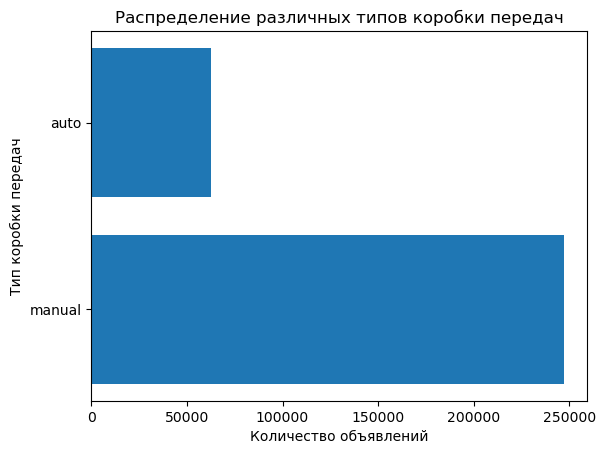

In [35]:
plt.barh(data['gearbox'].value_counts().index, data['gearbox'].value_counts())
plt.xlabel('Количество объявлений')
plt.ylabel('Тип коробки передач')
plt.title('Распределение различных типов коробки передач')
plt.show()

Заполним пропуски!

In [36]:
data = fill_col(data, ['brand', 'model','power', 'vehicle_type', 'fuel_type'], 'gearbox')

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324793 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        324793 non-null  datetime64[ns]
 1   price               324793 non-null  int64         
 2   vehicle_type        324793 non-null  object        
 3   registration_year   324793 non-null  int64         
 4   gearbox             324793 non-null  object        
 5   power               324793 non-null  int64         
 6   model               309774 non-null  object        
 7   kilometer           324793 non-null  int64         
 8   registration_month  324793 non-null  int64         
 9   fuel_type           302603 non-null  object        
 10  brand               324793 non-null  object        
 11  repaired            266966 non-null  object        
 12  date_created        324793 non-null  datetime64[ns]
 13  postal_code         324793 no

In [38]:
data['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'kadett', 'kangoo', 'one', 'fortwo', 'clio',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', '100', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'megane', 'lupo', 'r19', 'caddy',
       'mondeo', 'cordoba', 'colt', 'impreza', 'vectra', 'berlingo',
       'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe',
       'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe',
       '6er', 'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg',
       'l

Неявных дубликатов нет, заполним пропуски!

In [39]:
data = fill_col(data, ['brand', 'power', 'vehicle_type', 'fuel_type', 'gearbox'], 'model')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324793 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        324793 non-null  datetime64[ns]
 1   price               324793 non-null  int64         
 2   vehicle_type        324793 non-null  object        
 3   registration_year   324793 non-null  int64         
 4   gearbox             324793 non-null  object        
 5   power               324793 non-null  int64         
 6   model               324793 non-null  object        
 7   kilometer           324793 non-null  int64         
 8   registration_month  324793 non-null  int64         
 9   fuel_type           302603 non-null  object        
 10  brand               324793 non-null  object        
 11  repaired            266966 non-null  object        
 12  date_created        324793 non-null  datetime64[ns]
 13  postal_code         324793 no

In [41]:
data['power'].value_counts()

0       31665
75      21662
60      14452
150     13622
140     12213
        ...  
2789        1
519         1
2461        1
6006        1
1241        1
Name: power, Length: 680, dtype: int64

Нулевых значений в показателе мощности быть не может, поэтому заменим нули медианами по различным типам авто. 

In [42]:
def fill_col_median(data, features, target):    
    group_table = data.loc[:, features + [target]].groupby(features, as_index=False).median()
    data['col'] = data[features].merge(group_table, how='left', on=features)[target]
    data['power'].replace({0:np.nan}, inplace=True) 
    data[target].fillna(data['col'], inplace=True)
    data.dropna(subset=target, inplace=True)
    data.drop('col', axis=1, inplace=True)
    return data

In [43]:
data = fill_col_median(data, ['brand', 'model', 'vehicle_type', 'fuel_type', 'gearbox'], 'power')

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320120 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        320120 non-null  datetime64[ns]
 1   price               320120 non-null  int64         
 2   vehicle_type        320120 non-null  object        
 3   registration_year   320120 non-null  int64         
 4   gearbox             320120 non-null  object        
 5   power               320120 non-null  float64       
 6   model               320120 non-null  object        
 7   kilometer           320120 non-null  int64         
 8   registration_month  320120 non-null  int64         
 9   fuel_type           299121 non-null  object        
 10  brand               320120 non-null  object        
 11  repaired            264653 non-null  object        
 12  date_created        320120 non-null  datetime64[ns]
 13  postal_code         320120 no

Нули заполнить удалось!

In [45]:
data['kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000], dtype=int64)

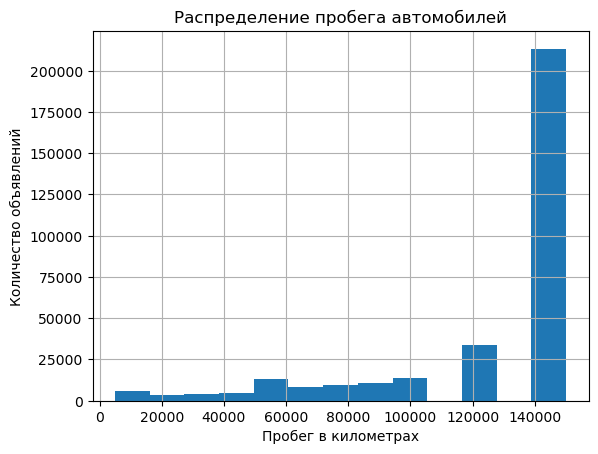

In [46]:
data['kilometer'].hist(bins=13)
plt.xlabel('Пробег в километрах')
plt.ylabel('Количество объявлений')
plt.title('Распределение пробега автомобилей')
plt.show()

Выбросов и пропусков нет, данные имеют адекватные значения. 

In [47]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполним пропуски!

In [48]:
data = fill_col(data, ['brand', 'model', 'power', 'vehicle_type', 'gearbox'], 'fuel_type')

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320120 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        320120 non-null  datetime64[ns]
 1   price               320120 non-null  int64         
 2   vehicle_type        320120 non-null  object        
 3   registration_year   320120 non-null  int64         
 4   gearbox             320120 non-null  object        
 5   power               320120 non-null  float64       
 6   model               320120 non-null  object        
 7   kilometer           320120 non-null  int64         
 8   registration_month  320120 non-null  int64         
 9   fuel_type           320120 non-null  object        
 10  brand               320120 non-null  object        
 11  repaired            264653 non-null  object        
 12  date_created        320120 non-null  datetime64[ns]
 13  postal_code         320120 no

In [50]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'sonstige_autos',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'citroen', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'chrysler', 'jaguar', 'daewoo', 'porsche', 'rover',
       'saab', 'land_rover', 'lada'], dtype=object)

Неявных дубликатов нет, пропусков нет.

In [51]:
data['repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [52]:
# Заменим пропуски на 'undef'
data['repaired'].fillna('undef', inplace=True)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320120 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        320120 non-null  datetime64[ns]
 1   price               320120 non-null  int64         
 2   vehicle_type        320120 non-null  object        
 3   registration_year   320120 non-null  int64         
 4   gearbox             320120 non-null  object        
 5   power               320120 non-null  float64       
 6   model               320120 non-null  object        
 7   kilometer           320120 non-null  int64         
 8   registration_month  320120 non-null  int64         
 9   fuel_type           320120 non-null  object        
 10  brand               320120 non-null  object        
 11  repaired            320120 non-null  object        
 12  date_created        320120 non-null  datetime64[ns]
 13  postal_code         320120 no

In [54]:
data['postal_code'].sort_values().unique()

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998], dtype=int64)

Значение почтового индекса не совсем стандартное, выяснить у заказчика - ошибка это или нет. Пока оставляем!

In [55]:
data['last_seen'].sort_values().unique()

array(['2016-03-05T14:15:08.000000000', '2016-03-05T14:15:16.000000000',
       '2016-03-05T14:15:39.000000000', ...,
       '2016-04-07T14:58:49.000000000', '2016-04-07T14:58:50.000000000',
       '2016-04-07T14:58:51.000000000'], dtype='datetime64[ns]')

In [56]:
# Проверим и удалим при наличии случаи, когда последняя активность пользователя была раньше даты создания анкеты
data.query('last_seen >= date_created', inplace=True)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320120 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        320120 non-null  datetime64[ns]
 1   price               320120 non-null  int64         
 2   vehicle_type        320120 non-null  object        
 3   registration_year   320120 non-null  int64         
 4   gearbox             320120 non-null  object        
 5   power               320120 non-null  float64       
 6   model               320120 non-null  object        
 7   kilometer           320120 non-null  int64         
 8   registration_month  320120 non-null  int64         
 9   fuel_type           320120 non-null  object        
 10  brand               320120 non-null  object        
 11  repaired            320120 non-null  object        
 12  date_created        320120 non-null  datetime64[ns]
 13  postal_code         320120 no

### Подготовка данных к загрузке в модели

- выделим target и features
- необходимо закодировать категориальные переменные, так как перед нами стоит задача регрессии. Применим OneHotEncoder
- выделим обучающую и тестовую выборки. Валидационную не будем выделять, потому что будем использовать кросс-валидацию (RandomizedSearchCV)

In [58]:
y = data['price']
X = data.drop(data.select_dtypes('datetime64[ns]').columns.to_list() + ['price', 'model'], axis=1)
# пришлось удалить важный признак model, потому что возникала ошибка нехватки памяти!!!

obj_columns = X.select_dtypes('object').columns

ohe = OneHotEncoder(sparse=False, drop='first')
X_ohe = ohe.fit_transform(X[obj_columns])
X[ohe.get_feature_names()] = pd.DataFrame(X_ohe, columns=ohe.get_feature_names())
X.drop(obj_columns, axis=1, inplace=True)
X.fillna(0, inplace=True) #чтобы не выдавал ошибок для моделей дерево решений и случайный лес

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM)

## Обучение моделей

### LinearRegression model

In [59]:
def best_model_lr(X_train, y_train):
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(mean_squared_error(y_valid, prediction, squared=False))
    best_params.append(model.get_params)
    print('Значение RMSE = ', mean_squared_error(y_valid, prediction, squared=False))
    return model 

In [60]:
%%time
lr_model = best_model_lr(X_train, y_train)

Значение RMSE =  3779.58468305305
CPU times: total: 2.92 s
Wall time: 1.63 s


In [61]:
%%time
lr_model.predict(X_train)

CPU times: total: 438 ms
Wall time: 109 ms


array([3941.04952375, 2926.91578622, 4888.01768922, ..., 6777.43364984,
       2726.8233869 , 6571.35602897])

### DecisionTreeRegressor model

In [62]:
def best_model_dtr(X_train, y_train):
    model = DecisionTreeRegressor(random_state=RANDOM)
    params = {'max_depth':range(1,10), 'min_samples_split':range(2,10), 'min_samples_leaf':range(1,10)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [63]:
%%time
dtr_model = best_model_dtr(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Значение RMSE =  2259.147745481693
Лучшие параметры модели: {'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 9}
CPU times: total: 4.11 s
Wall time: 33.6 s


In [64]:
%%time
dtr_model.predict(X_train)

CPU times: total: 188 ms
Wall time: 172 ms


array([3321.02914573, 1167.70382548, 5149.73214286, ..., 9484.2962963 ,
       1521.87579178, 4136.24924925])

### RandomForestRegressor model

In [65]:
# Для начала найдем лучшие параметры модели на небольшом количестве деревьев 
#с целью экономии времени обучения, а в целом можно и нужно количество деревьев сразу смотреть.
# Затем подберем такой гиперпараметр как количество деревьев
def best_model_rfc(X_train, y_train):
    model = RandomForestRegressor(random_state=123, n_estimators=10)
    params = {'max_depth':range(1,10), 'min_samples_split':range(2,5), 'min_samples_leaf':range(1,5)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model = RandomForestRegressor(random_state=123)
    params = {'n_estimators':range(20,200,30), 
              'max_depth':[grid_model.best_params_['max_depth']],
              'min_samples_split':[grid_model.best_params_['min_samples_split']],
              'min_samples_leaf':[grid_model.best_params_['min_samples_leaf']]}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [66]:
%%time
rfc_model = best_model_rfc(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Значение RMSE =  2219.5695624049913
Лучшие параметры модели: {'n_estimators': 170, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 9}
CPU times: total: 5min 18s
Wall time: 30min 49s


In [67]:
%%time
rfc_model.predict(X_train)

CPU times: total: 5 s
Wall time: 5 s


array([3014.65700379, 1198.53534637, 5469.78881219, ..., 9105.3819848 ,
       1581.03113523, 4056.50079039])

### LGBMRegresssor model

In [68]:
def best_model_lgbm(X_train, y_train):
    model = LGBMRegressor(random_state=RANDOM)
    params = {'max_depth':range(1,10), 'min_data_in_leaf':range(1,20)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [69]:
%%time
lgbm_model = best_model_lgbm(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
Значение RMSE =  2174.825956575879
Лучшие параметры модели: {'min_data_in_leaf': 12, 'max_depth': 8}
CPU times: total: 9.38 s
Wall time: 50.9 s


In [70]:
%%time
lgbm_model.predict(X_train)

CPU times: total: 3.36 s
Wall time: 541 ms


array([2741.33350299, 1370.18149488, 5540.50503278, ..., 8915.18202352,
       1443.07318736, 3767.35781242])

### CatBoostRegressor model

In [71]:
def best_model_cbr(X_train, y_train):
    model = CatBoostRegressor(random_state=RANDOM)
    params = {'max_depth':range(2,10), 'iterations':range(20,100, 20)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=0, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [72]:
%%time
cbr_model = best_model_cbr(X_train, y_train)

Learning rate set to 0.5
0:	learn: 3178.1295221	total: 197ms	remaining: 15.6s
1:	learn: 2612.2522514	total: 257ms	remaining: 10s
2:	learn: 2409.5772881	total: 307ms	remaining: 7.87s
3:	learn: 2328.4608060	total: 356ms	remaining: 6.77s
4:	learn: 2293.7230189	total: 403ms	remaining: 6.05s
5:	learn: 2272.9727255	total: 447ms	remaining: 5.51s
6:	learn: 2257.4165101	total: 495ms	remaining: 5.16s
7:	learn: 2249.8101437	total: 559ms	remaining: 5.03s
8:	learn: 2241.2424748	total: 607ms	remaining: 4.79s
9:	learn: 2231.8442867	total: 653ms	remaining: 4.57s
10:	learn: 2226.5003327	total: 700ms	remaining: 4.39s
11:	learn: 2220.8047225	total: 750ms	remaining: 4.25s
12:	learn: 2217.5625902	total: 796ms	remaining: 4.1s
13:	learn: 2215.3389240	total: 840ms	remaining: 3.96s
14:	learn: 2213.1748312	total: 885ms	remaining: 3.83s
15:	learn: 2209.6528422	total: 934ms	remaining: 3.73s
16:	learn: 2206.2601444	total: 979ms	remaining: 3.63s
17:	learn: 2204.0752092	total: 1.02s	remaining: 3.53s
18:	learn: 2199.

In [73]:
%%time
cbr_model.predict(X_train)

CPU times: total: 641 ms
Wall time: 109 ms


array([2804.09775504, 1419.71836805, 5569.59611999, ..., 9682.78618325,
       1519.47456454, 3895.83438333])

In [76]:
# создадим сводную таблицу по результатам теста
top_list_df = pd.DataFrame({'Model':model_list, 
                            'RMSE':rmse_score_list,
                            'Best parameters':best_params }).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
top_list_df

,Model,RMSE,Best parameters
0,CatBoostRegressor,2167.272904,"{'max_depth': 9, 'iterations': 80}"
1,LGBMRegressor,2174.825957,"{'min_data_in_leaf': 12, 'max_depth': 8}"
2,RandomForestRegressor,2219.569562,"{'n_estimators': 170, 'min_samples_split': 3, ..."
3,DecisionTreeRegressor,2259.147745,"{'min_samples_split': 3, 'min_samples_leaf': 7..."
4,LinearRegression,3779.584683,<bound method BaseEstimator.get_params of Line...


## Анализ моделей

В ходе исследования нами было оценено 5 моделей для прогнозирования цены продаваемого автомобиля. Наилучшие показатели (время обучения, время предсказания и качество предсказания) оказались у модели CatBoostRegressor. Именно данная модель будет применяться для прогнозирования цены!

| Модель                | Время обучения      | Время предсказания | RMSE |
| :---:                 |    :----:           |          :---:     | :---:|
| LinearRegression      | 1.6 s              | 109 ms            | 3780 |
| DecisionTreeRegressor | 33.6 s              | 172 ms            | 2259 |
| RandomForestRegressor | 30 min 49 s         | 5 s             | 2219 |
| LGBMRegressor     | 50 s          | 541 ms         | 2174 |
| **CatBoostRegressor**     | **64 s**              | **109 ms**            | **2167** |     



Проверим работу модели на тестовых данных!

In [79]:
prediction = cbr_model.predict(X_test)
final_rmse = mean_squared_error(y_test, prediction, squared=False)
final_rmse

2179.4570126012236

Лучшей моделью для прогнозирования цены автомобиля признана модель CatBoostRegressor c гиперпараметрами max_depth = 9, iterations = 80. Итоговое значение RMSE на тестовых данных составило 2179. Модель успешно прошла тестирование!

## Выводы

Перед нами стояла задача разработки модели, прогнозирующей рыночную цену автомобиля на основе технических характеристик, комплектации и других признаков. 

Заказчику были важны важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

В ходе подготовки данных было выполнено:
- загрузка данных;
- удаление дубликатов;
- переопределение типов данных в столбцах;
- создание новых признаков;
- обработка выбросов, пропусков, аномалий; 
- кодировка категориальных признаков;
- разделение данных на тренировочную и тестовую выборки;
- обучение моделей

В ходе исследования нами было оценено 5 моделей для прогнозирования цены продаваемого автомобиля. Наилучшие показатели (время обучения, время предсказания и качество предсказания) оказались у модели CatBoostRegressor. Именно данная модель будет применяться для прогнозирования цены!

| Модель                | Время обучения      | Время предсказания | RMSE |
| :---:                 |    :----:           |          :---:     | :---:|
| LinearRegression      | 1.6 s              | 109 ms            | 3780 |
| DecisionTreeRegressor | 33.6 s              | 172 ms            | 2259 |
| RandomForestRegressor | 30 min 49 s         | 5 s             | 2219 |
| LGBMRegressor     | 50 s          | 541 ms         | 2174 |
| **CatBoostRegressor**     | **64 s**              | **109 ms**            | **2167** |  


Лучшей моделью для прогнозирования цены автомобиля признана модель CatBoostRegressor c гиперпараметрами max_depth = 9, iterations = 80. Итоговое значение RMSE на тестовых данных составило 2179. Модель успешно прошла тестирование!